# Define environement variables and import the data

In [2]:
# Import external packages
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
#import mpld3
#mpld3.enable_notebook()

# Import local packages
import load_csv_from_zip as lcfz

# Set some display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [ ]:
train, submission = lcfz.read_csv_from_zip('./../../data/input/bike-sharing-demand', ['train', 'test'])

In [3]:
path_to_file = './'
train_filename = 'train.csv'
test_filename = 'test.csv'

In [4]:
with open(path_to_file+train_filename) as file:
    train = pd.read_csv(file)
    
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


# Look at the data structure

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [6]:
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

### Summary
At first glance, the training set is made of 10886 records with no missing values.<br>
The datetime column should be turned into a pandas.DatetimeIndex.<br>
The count column is the target variable.<br>
The casual and registered are not present in the test data and cannot be used for the ML algo.<br>
There is one nominal variable: Season.<br>
There are 2 binary variables: holiday, workingday.<br>
There is 1 ordinal variable: Weather.<br>
There are 4 continuous variables: temp, atemp, humidity, windspeed.<br>

# Use the datetime column as the index to make data manipulation easier

In [7]:
train.set_index(pd.to_datetime(train.pop('datetime')), inplace=True)

In [8]:
train['dayofweek'] = train.index.dayofweek
train['dayofyear'] = train.index.dayofyear
train['month'] = train.index.month
train['year'] = train.index.year
train['hour'] = train.index.hour

train.sample(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,dayofyear,month,year,hour
datetime,,,,,,,,,,,,,,,,
2012-08-06 19:00:00,3,0,1,1,31.98,37.120,59,12.9980,109,531,640,0,219,8,2012,19
2012-05-08 19:00:00,2,0,1,2,26.24,30.305,69,19.0012,59,399,458,1,129,5,2012,19
2012-03-04 18:00:00,1,0,0,1,13.12,13.635,33,40.9973,20,164,184,6,64,3,2012,18
2011-03-09 13:00:00,1,0,1,2,13.12,14.395,76,23.9994,17,82,99,2,68,3,2011,13
2012-02-17 10:00:00,1,0,1,1,13.94,15.910,71,19.0012,13,103,116,4,48,2,2012,10


In [9]:
train.year.unique()

array([2011, 2012], dtype=int64)

In [10]:
train.year.value_counts()

2012    5464
2011    5422
Name: year, dtype: int64

In [11]:
train['2011'].month.value_counts().sort_index()

1     431
2     446
3     446
4     455
5     456
6     456
7     456
8     456
9     453
10    455
11    456
12    456
Name: month, dtype: int64

For convenience, the date and time are converted into a DatetimeIndex and the hour, day, month and year components are extracted as individual features.

We check that each period roughly has the same amount of data.

## Try to identifiy gaps in the data

In [12]:
train['delta_t'] = train.index.to_series().diff()
train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,dayofyear,month,year,hour,delta_t
datetime,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,5,1,1,2011,0,NaT
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,5,1,1,2011,1,0 days 01:00:00
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,5,1,1,2011,2,0 days 01:00:00
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,5,1,1,2011,3,0 days 01:00:00
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,5,1,1,2011,4,0 days 01:00:00


In [13]:
train['delta_t'].fillna(pd.Timedelta('0 hour'))
train[(train['delta_t']>pd.Timedelta('1 hours')) & (train['delta_t']< pd.Timedelta('1 days'))]['delta_t']

datetime
2011-01-02 06:00:00   0 days 02:00:00
2011-01-03 04:00:00   0 days 03:00:00
2011-01-04 04:00:00   0 days 02:00:00
2011-01-05 04:00:00   0 days 02:00:00
2011-01-06 04:00:00   0 days 02:00:00
2011-01-07 04:00:00   0 days 02:00:00
2011-01-11 05:00:00   0 days 03:00:00
2011-01-12 05:00:00   0 days 03:00:00
2011-01-14 05:00:00   0 days 02:00:00
2011-01-18 12:00:00   0 days 13:00:00
2011-01-19 04:00:00   0 days 02:00:00
2011-02-01 05:00:00   0 days 02:00:00
2011-02-03 05:00:00   0 days 02:00:00
2011-02-04 05:00:00   0 days 02:00:00
2011-02-09 05:00:00   0 days 02:00:00
2011-02-10 04:00:00   0 days 02:00:00
2011-02-11 05:00:00   0 days 03:00:00
2011-02-13 06:00:00   0 days 02:00:00
2011-02-15 04:00:00   0 days 02:00:00
2011-02-16 03:00:00   0 days 02:00:00
2011-03-06 06:00:00   0 days 02:00:00
2011-03-07 03:00:00   0 days 02:00:00
2011-03-10 05:00:00   0 days 03:00:00
2011-03-11 05:00:00   0 days 02:00:00
2011-03-13 03:00:00   0 days 02:00:00
2011-03-14 05:00:00   0 days 02:00:00
201

Here we just create a column holding the time delta (difference) from one row wrt the previous one. After that, we selected only the rows where this difference was greater than the regular sampling interval but also shorter than an entire day. We can notice that there are only a few records corresponding to this request and that they mostly occur at night. The missing rows probably correspond to hours where the 'count' value was equal to 0.

In [14]:
train[(train['delta_t']>pd.Timedelta('1 day'))]['delta_t']

datetime
2011-02-01   12 days 01:00:00
2011-03-01    9 days 01:00:00
2011-04-01   12 days 01:00:00
2011-05-01   11 days 01:00:00
2011-06-01   12 days 01:00:00
2011-07-01   11 days 01:00:00
2011-08-01   12 days 01:00:00
2011-09-01   12 days 01:00:00
2011-10-01   11 days 01:00:00
2011-11-01   12 days 01:00:00
2011-12-01   11 days 01:00:00
2012-01-01   12 days 01:00:00
2012-02-01   12 days 01:00:00
2012-03-01   10 days 01:00:00
2012-04-01   12 days 01:00:00
2012-05-01   11 days 01:00:00
2012-06-01   12 days 01:00:00
2012-07-01   11 days 01:00:00
2012-08-01   12 days 01:00:00
2012-09-01   12 days 01:00:00
2012-10-01   11 days 01:00:00
2012-11-01   12 days 01:00:00
2012-12-01   11 days 01:00:00
Name: delta_t, dtype: timedelta64[ns]

This time, we look at the missing rows where the time delta is greater than 1 day. We notice that the 9 to 12 last days of each months are systematically missing. This correspond to the data that has been removed on purpose to create the test set.

In [15]:
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,dayofweek,dayofyear,month,year,hour,delta_t
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10885
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132,3.013963,177.562466,6.521495,2011.501929,11.541613,0 days 01:35:06.752411575
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454,2.004585,105.055551,3.444373,0.500019,6.915838,0 days 12:37:53.057753057
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2011.000000,0.000000,0 days 01:00:00
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000,1.000000,92.000000,4.000000,2011.000000,6.000000,0 days 01:00:00
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000,3.000000,182.500000,7.000000,2012.000000,12.000000,0 days 01:00:00
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000,5.000000,274.000000,10.000000,2012.000000,18.000000,0 days 01:00:00
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000,6.000000,354.000000,12.000000,2012.000000,23.000000,12 days 01:00:00


One important thing to notice here is that the min of 'count' is 1 and not 0. Here, I will assume that when the 'delta_t' is only a few hours (only at night as can be seen above), there are no records because the value of 'count' is actually 0. <font color=red>It would be interesting to compare a ML algo with/-out adding rows when 'count' is 0.</font>

One troubling thing in this data set are the values of the temp and atemp features. We can see here that the minimum temperature is positive. Knowing that this bike sharing program was in Washington DC and that winters can get prettu cold there, this seems unlikely to be the actual temperature. (To understand how I figured out that the program was in Washington DC, I suggest you dig in the "holiday" feature...).

# Univariate and Bivariate analysis

Let's now have a look at the features one by one to get a better feeling of what they represent and how can they impact our target variable.

In [16]:
cat_features = ['season']
ord_featuire = ['weather']
bin_features = ['holiday', 'workingday']
num_features = ['temp', 'atemp', 'humidity', 'windspeed']
other_features = ['casual', 'registered']
target_variable = ['count']

## Categorical features

### Season

<AxesSubplot:title={'center':'count'}, xlabel='season'>

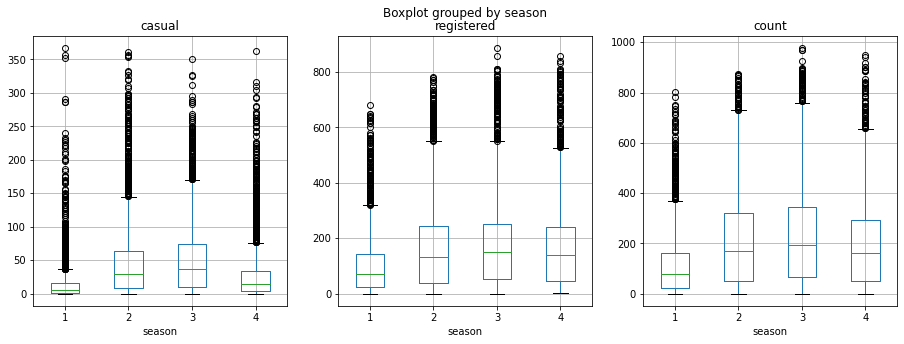

In [17]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
train.boxplot(column='casual', by='season', ax=ax[0])
train.boxplot(column='registered', by='season', ax=ax[1])
train.boxplot(column='count', by='season', ax=ax[2])

This box plot shows that there is a higher demand during spring and summer probably due to weather conditions (higher temperatures, less rain, ...). We can also notice that there is less variability for 'registered' customers than for 'casual' ones.

### Weather

<AxesSubplot:title={'center':'count'}, xlabel='weather'>

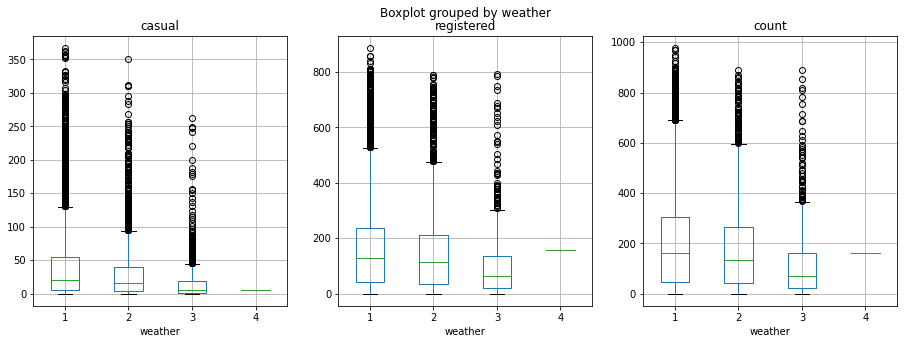

In [18]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
train.boxplot(column='casual', by='weather', ax=ax[0])
train.boxplot(column='registered', by='weather', ax=ax[1])
train.boxplot(column='count', by='weather', ax=ax[2])

Here we see again that the better the weather, the higher the demand which makes sense. Also, we can notice that for the weather category #4, there is only 1 entry and its value is quite high. <font color=red>We might want to remove this record to avoid biasing our model.</font>

## Numerical features

### Temperature

<AxesSubplot:title={'center':'count'}, xlabel='temp_bin'>

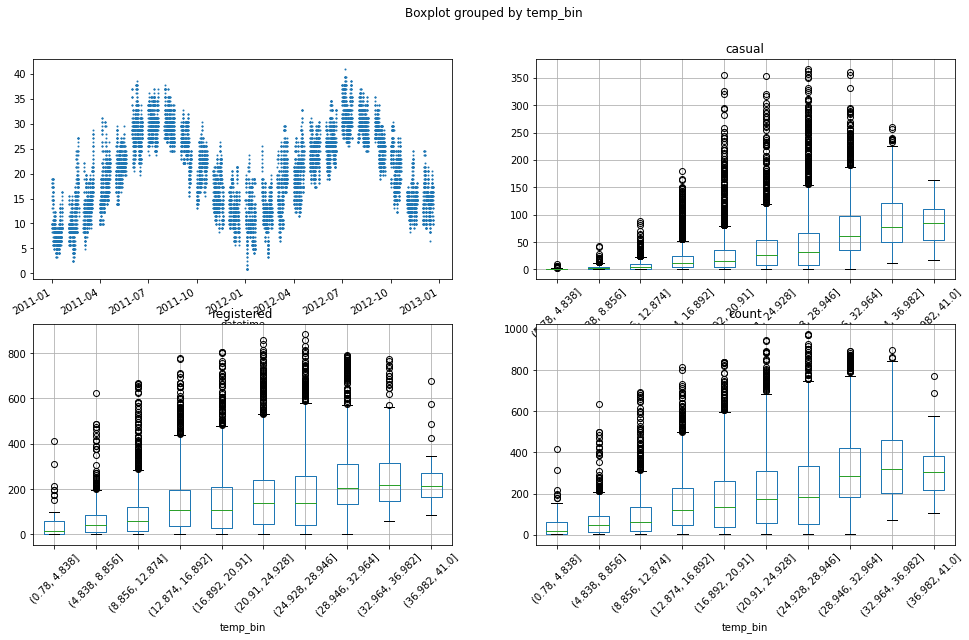

In [19]:
train['temp_bin'] = pd.cut(train['temp'], 10)
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train['temp'].plot(linewidth=0, marker='o', markersize=1, ax=ax[0][0])
train.boxplot(column='casual', by='temp_bin', ax=ax[0][1], rot=45)
train.boxplot(column='registered', by='temp_bin', ax=ax[1][0], rot=45)
train.boxplot(column='count', by='temp_bin', ax=ax[1][1], rot=45)

We can observe here an anual modulation corresponding to the seasons. Hot in summer, cold in winter.

There is a clear correlation between the temperature and the bike demand.
For low temperatures, the demand by casual users is almost inexistant while registered users tend to keep using the bikes (seems reasonable).
The demand increases with temperature and actually reaches a maximum for temperature in the range 2-35 degrees (according to the median, mean might be different).

<font color='red'>One other thing to keep in mind is that temperatures are 'always' lower at night and higher during the day! At the same time, people probably tend to use the bikes more during the day than at night for independant reasons. So we might have so amount of colinearity between those features.</font>

<AxesSubplot:xlabel='datetime'>

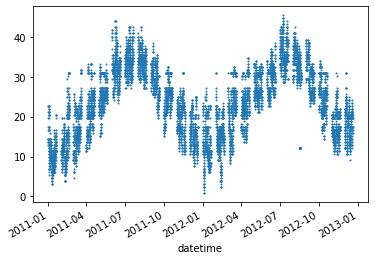

In [20]:
train['atemp'].plot(linewidth=0, marker='o', markersize=1)

For some reason, the adjusted temperature looks worse than the simple temperature feature. There seems to be gaps in the data. <font color=red>I will have to check for multicolinearity for 'temp'/'atemp' and see if there is an advantage of using 'atemp' over 'temp'. If so, I should do something about those "strange" values. Recalculate 'atemp' from other variables? Use an ML algo for that?</font>

### Humidity

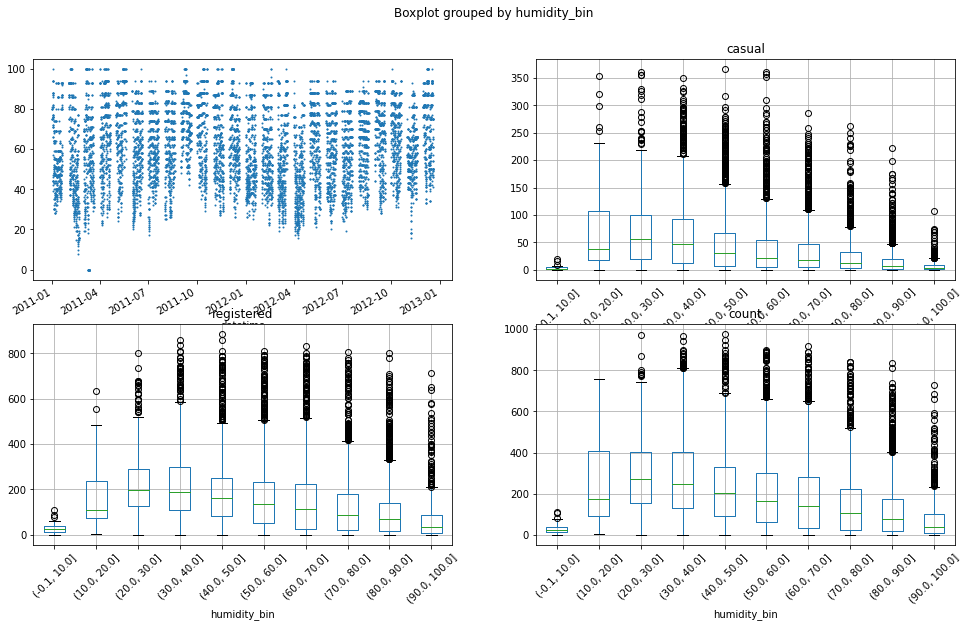

In [20]:
train['humidity_bin'] = pd.cut(train['humidity'], 10)
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train['humidity'].plot(linewidth=0, marker='o', markersize=1, ax=ax[0][0])
train.boxplot(column='casual', by='humidity_bin', ax=ax[0][1], rot=45)
train.boxplot(column='registered', by='humidity_bin', ax=ax[1][0], rot=45)
train.boxplot(column='count', by='humidity_bin', ax=ax[1][1], rot=45)

Regarding humidity, there is also a correlation with the demand. Very dry conditions (below 10% humidity) show little demand, and this is true for all types of users. Beyond 20% humidity, the demands slowly falls but is always higher than very dry conditions. 

### Windspeed

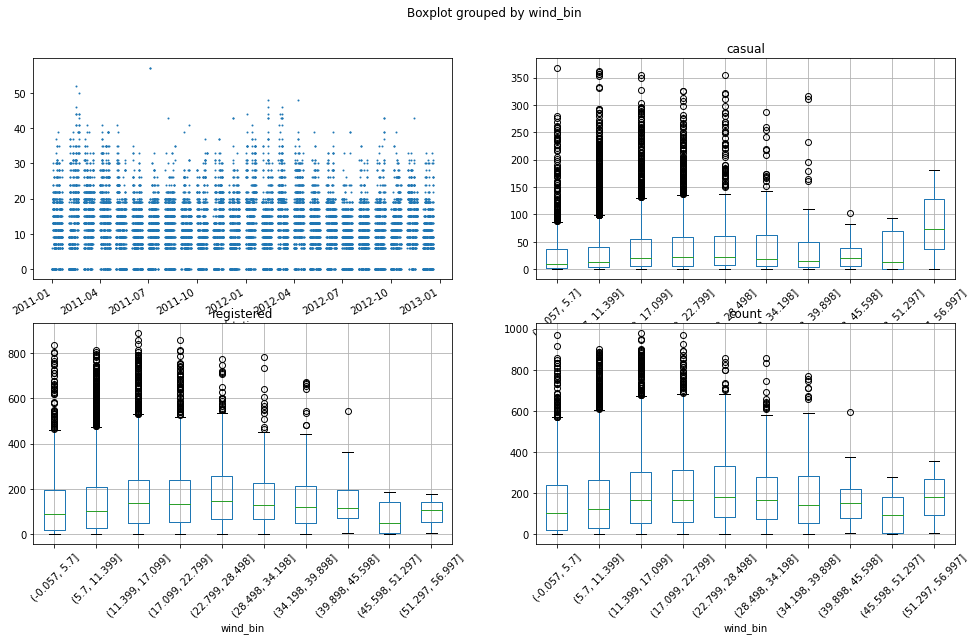

In [21]:
train['wind_bin'] = pd.cut(train['windspeed'], 10)
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train['windspeed'].plot(linewidth=0, marker='o', markersize=1, ax=ax[0][0])
train.boxplot(column='casual', by='wind_bin', ax=ax[0][1], rot=45)
train.boxplot(column='registered', by='wind_bin', ax=ax[1][0], rot=45)
train.boxplot(column='count', by='wind_bin', ax=ax[1][1], rot=45)

Finally for the windspeed feature, the demand seems pretty stable but the distribution of counts becomes more symmetric (less skewed, less outliers) at higher windspeed. As if users (casual or registered) that would use the bikes occasionnaly would not use them in strong wind conditions whereas people who tend to be very consistent using bikes still use them.

### Hour of the day

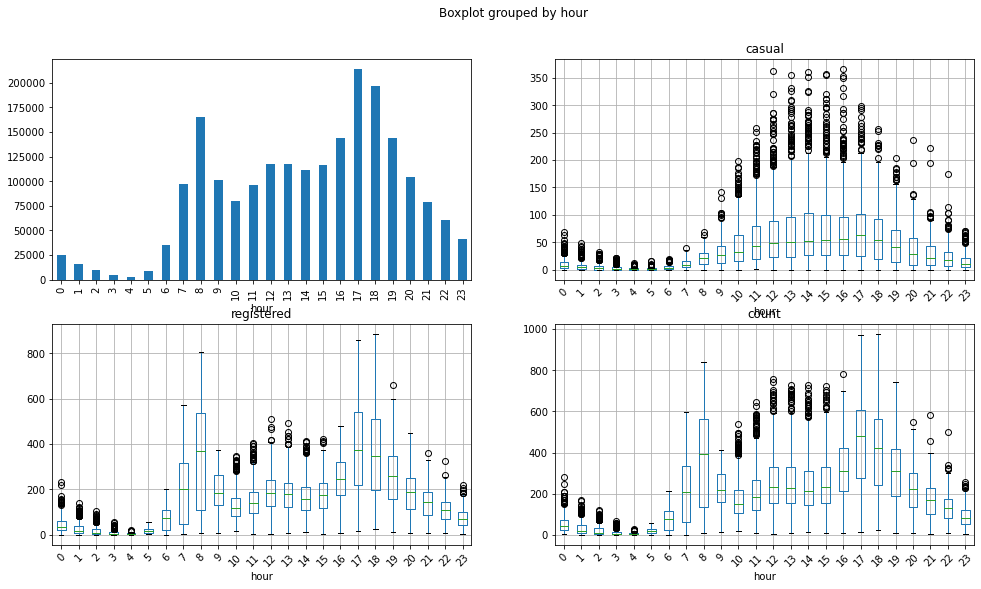

In [22]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train.groupby('hour')['count'].sum().plot(kind='bar', ax=ax[0][0])
train.boxplot(column='casual', by='hour', ax=ax[0][1], rot=45)
train.boxplot(column='registered', by='hour', ax=ax[1][0], rot=45)
train.boxplot(column='count', by='hour', ax=ax[1][1], rot=45)

As we could have expected, the hour of the day is a very important feature to predict the bike demand. Also, something interesting to note here is that the profile for registered and casual users is quite different.

While registered users seem to bike for work (higher demand around 8AM, 5/6PM) and little more at lunch time, casual users have a much smoother curve with a broad maximum peaking around 2/3PM.

For this reason, it would be interesting to build <font color=red>2 separate models!</font> One to predict the number of registered users and another one for casual users. These two models will probably end up having different parameters and summing them up might result in better results than trying to predict the overall demand with a single model.

<font color='red'>One more remark: Here we groupby hours regardless of the season of the year or the day of the week for example. It is expected that if we looked at 'registered' counts for weekdays only and excluding holidays and vacations, the correlation with the target variable would be even stronger!</font>

### Day of the week

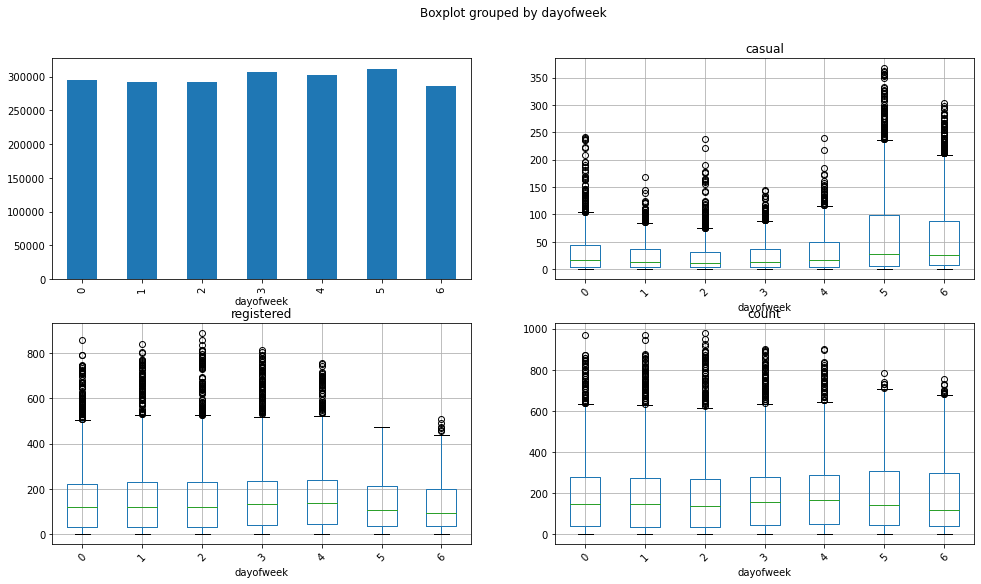

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train.groupby('dayofweek')['count'].sum().plot(kind='bar', ax=ax[0][0])
train.boxplot(column='casual', by='dayofweek', ax=ax[0][1], rot=45)
train.boxplot(column='registered', by='dayofweek', ax=ax[1][0], rot=45)
train.boxplot(column='count', by='dayofweek', ax=ax[1][1], rot=45)

Once again, the data behaves as expected with the demand from registered users being higher during the week and slightly lower during the weekend. For casual user, this is the other way around.

This is another good reason why two independant models should be trained for registered and casual and the individual predictions summed up.

### Month of the year

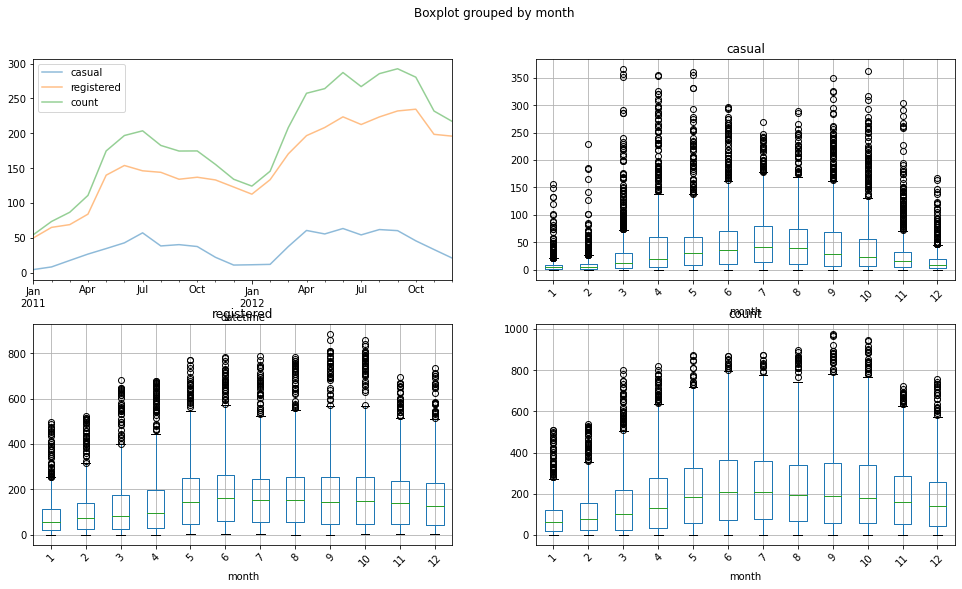

In [24]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train[['casual', 'registered', 'count']].resample('1M').mean().plot(ax=ax[0][0], alpha=0.5)
train.boxplot(column='casual', by='month', ax=ax[0][1], rot=45)
train.boxplot(column='registered', by='month', ax=ax[1][0], rot=45)
train.boxplot(column='count', by='month', ax=ax[1][1], rot=45)

Regarding the month of the year, we observe a similar pattern as we did with the season feature. The difference being that we have a higher granularity using the months.

For registered users, once again, the median demand is smoother than for casual user and varies less.

Another thing to notice is the drop in "high" demand (outliers and tail of the distributions) during the months of June, July, August for casual users. This behavior is much less pronounced for registered users but still appears.
This is interesting because it correspond to a period of the year where children are on vacations and maybe, families are away from DC.

As a consequence, we should look up the school vacation calendar for 2011/2012 and create a feature 'vacation'. This could improve the predictions of our model.

### Year

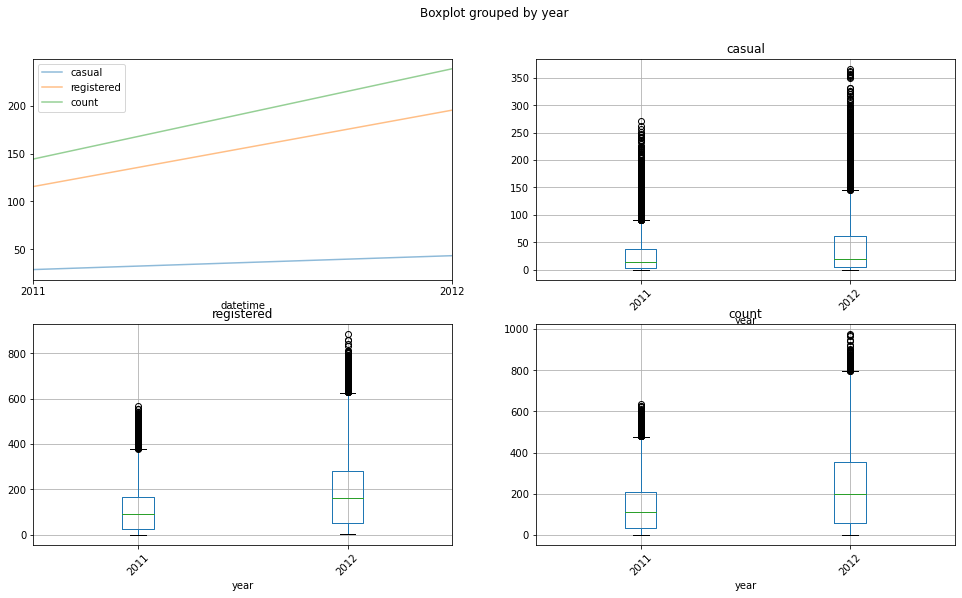

In [25]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train[['casual', 'registered', 'count']].resample('1Y').mean().plot(ax=ax[0][0], alpha=0.5)
train.boxplot(column='casual', by='year', ax=ax[0][1], rot=45)
train.boxplot(column='registered', by='year', ax=ax[1][0], rot=45)
train.boxplot(column='count', by='year', ax=ax[1][1], rot=45)

### Fourier Analysis of the target variables

# Feature engineering

### Create a cyclic variable for the hour of the day

In [26]:
train['hour_cos'] = np.cos(2.0 * np.pi * train['hour'] / 24.0)

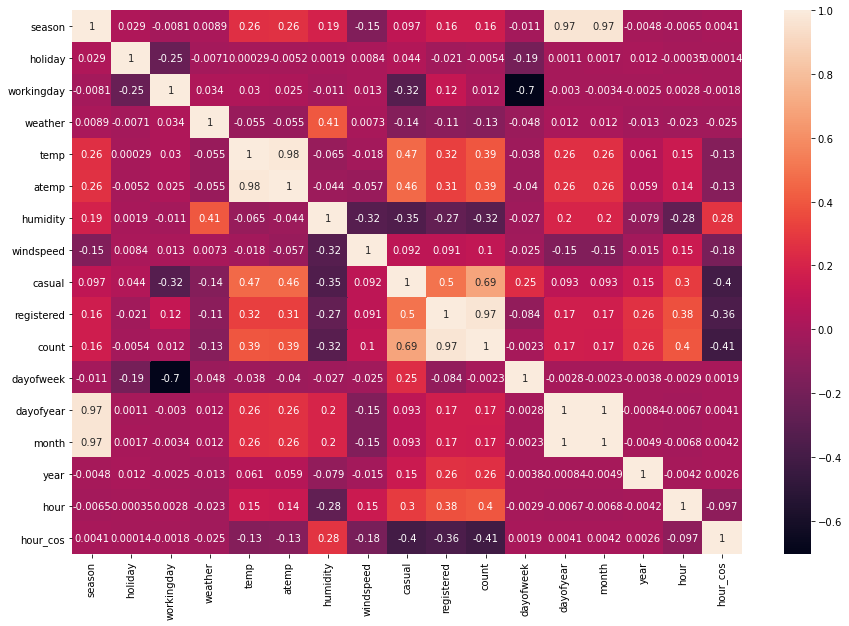

In [27]:
corr_matrix = train.corr()
fig = plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, annot=True)

Strong correlation between features:
 - temp and atemp... obvious. Must do something! (pick one)
 - windspeed and humidity (-0.32)
 - humidity and weather (0.41)
 - temp/atemp and season (0.26)
 - humidity and season (0.19)
 - workingday and holiday
 
 Now with the target variable:
 - season (0.16)
 - weather (-0.13)
 - temp/atemp (0.39)
 - humidity (-0.32)
 
 <font color=red>Try to turn categorical features (season, weather) into binary features (OneHotEncoding).
    Try to use KBinarizer for continuous features (temp/atemp, humidity, windspeed)

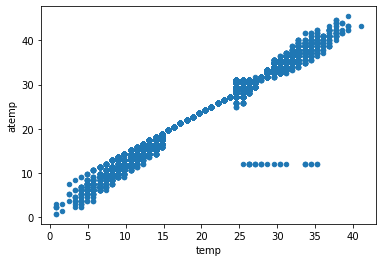

In [28]:
train.plot(kind='scatter', x='temp', y='atemp', marker='o')

First we can see outliers for which temp is in the range [25, 35] but atemp is always about 12.
<font color=red>If relation for atemp can be found, recalculate it myself, otherwise: remove entries with outliers or use temp.</font>

Second, there is a few points that seem to lie on a straight line: atemp = a*temp+b
<font color=red>Find the equation of the line, remove those points and thry to understand how the other points are obtained (linear regression using humidity and windspeed).</font>

Third, it seems that in the range temp = [15, 25], there is no other features explaining atemp.

## Creating a feature 'vacations'

In [29]:
train['vacations'] = 0

train.loc['2011-04-15':'2011-04-25', 'vacations'] = 1
train.loc['2011-06-25':'2011-08-21', 'vacations'] = 1
train.loc['2011-12-22':'2012-01-02', 'vacations'] = 1
train.loc['2012-03-31':'2012-04-09', 'vacations'] = 1
train.loc['2012-06-23':'2012-08-26', 'vacations'] = 1
train.loc['2012-12-22':'2012-12-31', 'vacations'] = 1

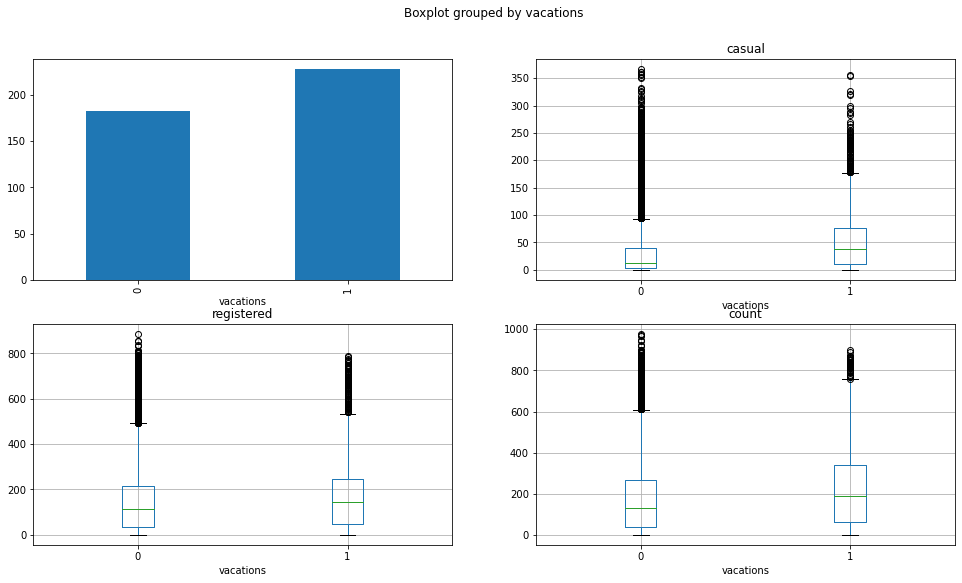

In [30]:
fig, ax = plt.subplots(2, 2, figsize=(16,9))
train.groupby('vacations')['count'].mean().plot(kind='bar', ax=ax[0][0])
train.boxplot(column='casual', by='vacations', ax=ax[0][1])
train.boxplot(column='registered', by='vacations', ax=ax[1][0])
train.boxplot(column='count', by='vacations', ax=ax[1][1])

Here it seems that the vacation feature impacts differently "different group of people". First, we see that the average demand is higher during vacations which might be due to tourists ? Also, we can notice an increase of the quantiles BUT the tail of the distributions are always shorter. The effect is more pronounced for casual users where the median almost increases by a factor of 2. Overall, the deman is higher and the distributions less skewed.

# Conclusions

Using the holiday feature, we learnt that the program is from Washington DC.

What we noticed is that despite the obvious correlation between the target variable and some of the features (months, year, hour of the day, temperature, ...) it would be hard for a linear regression model to have predictive power because there is no linear relationship between the target variable(s) and the features.
The only way to make it work would be to OneHot encode all of the features (after discretization for continuous variables) which would lead to a very large number of parameters.

Something important to keep in mind is that we should use the hour, day, month and year as predictors since they seem to affect the target variable(s).

There is something strange going on with the 'temp' and 'atemp' features. We never observe negative temperatures. We don't know how the 'atemp' variable is obtained and 'atemp' seems to have bad values. For the model, it will be necessary to either use 'temp' or 'atemp' after removing the bad values or correcting them. 

Finally, it seems that adding a binary feature for school vacations could improve the performances of the model.

In [31]:
df = train['2011-05']['count'].copy()
df = df.reset_index(drop=True)

In [32]:
from scipy import fft

In [33]:
from scipy import signal

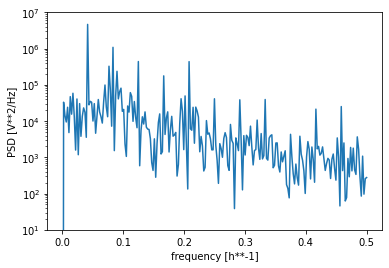

In [34]:
f, Pxx_den = signal.periodogram(df.values.ravel())
plt.semilogy(f, Pxx_den)
plt.ylim([1e1, 1e7])
plt.xlabel('frequency [h**-1]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

## Check for gaps in the test data

In [38]:
with open(path_to_file+test_filename) as file:
    test = pd.read_csv(file)

In [39]:
test.set_index(pd.to_datetime(test.pop('datetime')), inplace=True)

In [40]:
test['delta_t'] = test.index.to_series().diff()

In [41]:
test['delta_t'].fillna(pd.Timedelta('0 hour'))
test[(test['delta_t']>pd.Timedelta('1 hours')) & (test['delta_t']< pd.Timedelta('1 days'))]['delta_t']

datetime
2011-01-22 06:00:00   02:00:00
2011-01-23 05:00:00   02:00:00
2011-01-24 03:00:00   02:00:00
2011-01-25 04:00:00   02:00:00
2011-01-26 05:00:00   03:00:00
2011-01-27 16:00:00   23:00:00
2011-01-28 05:00:00   02:00:00
2011-01-29 06:00:00   02:00:00
2011-01-30 07:00:00   02:00:00
2011-02-20 06:00:00   02:00:00
2011-02-22 06:00:00   07:00:00
2011-02-23 05:00:00   02:00:00
2011-02-24 05:00:00   02:00:00
2011-02-25 05:00:00   02:00:00
2011-02-27 06:00:00   02:00:00
2011-02-28 03:00:00   02:00:00
2011-02-28 05:00:00   02:00:00
2011-03-21 05:00:00   02:00:00
2011-03-23 05:00:00   02:00:00
2011-03-27 06:00:00   02:00:00
2011-03-28 05:00:00   02:00:00
2011-08-28 07:00:00   14:00:00
2011-11-28 03:00:00   02:00:00
2011-12-25 05:00:00   02:00:00
2011-12-26 04:00:00   02:00:00
2011-12-28 05:00:00   02:00:00
2012-02-20 05:00:00   02:00:00
2012-02-21 04:00:00   02:00:00
2012-02-29 05:00:00   02:00:00
2012-11-29 04:00:00   02:00:00
2012-12-24 05:00:00   02:00:00
2012-12-25 04:00:00   02:00:00

It seems that in the test dataset, there is no entries with a total count of zero bikes. No need to create those rows to train the model.